In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import math
import argparse
import os

In [2]:
def resample_3d_line(points_3d, num_samples):
    """Resamples a 3D path to have a specific number of points."""
    if len(points_3d) < 2:
        return np.array([points_3d[0]] * num_samples) if len(points_3d) > 0 else np.empty((0, 3))
    
    distances = np.sqrt(np.sum(np.diff(points_3d, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)

    if cumulative_distances[-1] == 0:
        return np.array([points_3d[0]] * num_samples)

    sample_distances = np.linspace(0, cumulative_distances[-1], num_samples)
    
    sample_points = np.empty((num_samples, 3))
    sample_points[:, 0] = np.interp(sample_distances, cumulative_distances, points_3d[:, 0])
    sample_points[:, 1] = np.interp(sample_distances, cumulative_distances, points_3d[:, 1])
    sample_points[:, 2] = np.interp(sample_distances, cumulative_distances, points_3d[:, 2])

    return sample_points

In [3]:
def draw_semicircle(start_coord, radius, steps=150):
    x0, y0, z0 = start_coord
    center_x, center_y = x0, y0
    start = 0.2
    end = 0.8
    angles = np.linspace(start * np.pi, end * np.pi, steps)
    x = (center_x + radius) - radius * np.cos(angles)
    y = center_y - radius * np.sin(angles)
    z = np.full_like(x, z0)
    return x, y, z

In [4]:
def draw_T_shape(start_coord, bar_length, bar_height, steps=150):
    x0, y0, z0 = start_coord
    vertex1 = np.array([x0, y0, z0])
    vertex2 = np.array([x0, y0 + bar_length, z0])
    vertex3 = np.array([x0 + bar_height, y0 + bar_length / 2, z0])
    
    steps_per_section = steps // 3
    
    x_values_horizontal = np.linspace(vertex1[0], vertex2[0], steps_per_section)
    y_values_horizontal = np.linspace(vertex1[1], vertex2[1], steps_per_section)
    
    x_values_vertical = np.linspace(vertex2[0], vertex3[0], steps - steps_per_section)
    y_values_vertical = np.full_like(x_values_vertical, y0 + bar_length / 2)
    
    x_values = np.concatenate([x_values_horizontal, x_values_vertical])
    y_values = np.concatenate([y_values_horizontal, y_values_vertical])
    z_values = np.full_like(y_values, z0)
    
    return x_values, y_values, z_values

In [5]:
def draw_equilateral_triangle(start_coord, side_length, steps=150):
    x0, y0, z0 = start_coord
    vertex1 = np.array([x0, y0, z0])
    vertex2 = np.array([x0 + side_length, y0, z0])
    height = side_length * np.sqrt(3) / 2
    vertex3 = np.array([x0 + side_length / 2, y0 + height, z0])
    
    steps_per_side = steps // 3
    
    x_values = np.concatenate([
        np.linspace(vertex1[0], vertex2[0], steps_per_side),
        np.linspace(vertex2[0], vertex3[0], steps_per_side),
        np.linspace(vertex3[0], vertex1[0], steps - 2 * steps_per_side)
    ])
    y_values = np.concatenate([
        np.linspace(vertex1[1], vertex2[1], steps_per_side),
        np.linspace(vertex2[1], vertex3[1], steps_per_side),
        np.linspace(vertex3[1], vertex1[1], steps - 2 * steps_per_side)
    ])
    z_values = np.full_like(x_values, z0)
    
    return x_values, y_values, z_values

In [6]:
def draw_square(start_coord, side_length, steps=152):
    x0, y0, z0 = start_coord
    vertex1 = np.array([x0, y0, z0])
    vertex2 = np.array([x0 + side_length, y0, z0])
    vertex3 = np.array([x0 + side_length, y0 + side_length, z0])
    vertex4 = np.array([x0, y0 + side_length, z0])
    
    steps_per_side = steps // 4
    
    x_values = np.concatenate([
        np.linspace(vertex1[0], vertex2[0], steps_per_side),
        np.linspace(vertex2[0], vertex3[0], steps_per_side),
        np.linspace(vertex3[0], vertex4[0], steps_per_side),
        np.linspace(vertex4[0], vertex1[0], steps - 3 * steps_per_side)
    ])
    y_values = np.concatenate([
        np.linspace(vertex1[1], vertex2[1], steps_per_side),
        np.linspace(vertex2[1], vertex3[1], steps_per_side),
        np.linspace(vertex3[1], vertex4[1], steps_per_side),
        np.linspace(vertex4[1], vertex1[1], steps - 3 * steps_per_side)
    ])
    z_values = np.full_like(x_values, z0)
    
    return x_values, y_values, z_values

In [7]:
def rotate_numpy(points, angle_degrees=10):
    angle_radians = np.radians(angle_degrees)
    # Z-up rotation matrix (rotates around Z-axis)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians), 0],
        [np.sin(angle_radians), np.cos(angle_radians), 0],
        [0, 0, 1]
    ])
    return points @ rotation_matrix.T

In [8]:
def draw_up_down_line(start_z=.0, radius=0.1, theta_step=20, steps=150):
    theta = np.linspace(0, 2 * np.pi * steps / theta_step, steps)
    z_values = start_z + radius * np.sin(theta)
    x_values = np.zeros_like(z_values)
    y_values = np.zeros_like(z_values)
    return x_values, y_values, z_values

In [9]:
def draw_straight_line(start_coord, step_length, steps=150):
    x0, y0, z0 = start_coord
    x_values = np.linspace(x0, x0 + step_length * (steps-1), steps)
    y_values = np.full_like(x_values, y0)
    z_values = np.full_like(x_values, z0)
    return x_values, y_values, z_values

In [10]:
def draw_curve_line(start_coord, radius, step_length, theta_step=50, steps=150):
    x0, y0, z0 = start_coord
    x_values = np.linspace(x0, x0 + step_length * (steps-1), steps)
    theta = np.linspace(0, 2 * np.pi * steps / theta_step, steps)
    y_values = y0 + radius * np.sin(theta)
    z_values = np.full_like(x_values, z0)
    return x_values, y_values, z_values

In [11]:
def draw_curve_line2(start_coord, radius, step_length, theta_step=50, steps=150):
    x0, y0, z0 = start_coord
    x_values = np.linspace(x0, x0 + step_length * (steps-1), steps)
    theta = np.linspace(0, 2 * np.pi * steps / theta_step, steps)
    y_values = y0 + radius * np.cos(theta)
    z_values = np.full_like(x_values, z0)
    return x_values, y_values, z_values

In [12]:
def draw_circle(start_coord, radius, steps=150):
    x0, y0, z0 = start_coord
    center_x, center_y = x0, y0
    angles = np.linspace(0, 2 * np.pi, steps)
    x = (center_x - radius) + radius * np.cos(angles)
    y = center_y + radius * np.sin(angles)
    z = np.full_like(x, z0)
    return x, y, z

In [13]:
def draw_ellipse(start_coord, a, b, steps=150):
    x0, y0, z0 = start_coord
    center_x = x0 - a
    center_y = y0 + b
    angles = np.linspace(0, 2 * np.pi, steps)
    x = center_x + a * np.cos(angles)
    y = center_y - b + b * np.sin(angles)
    z = np.full_like(x, z0)
    return x, y, z

In [14]:
def draw_spiral(start_coord, radius, step_length, steps=150):
    x0, y0, z0 = start_coord
    z_values = np.linspace(z0, z0 + step_length * (steps-1), steps) # Height increases with steps
    theta = np.linspace(0, 2 * np.pi * steps / 20, steps)
    x_values = x0 + radius * np.cos(theta)
    y_values = y0 + radius * np.sin(theta)
    return x_values, y_values, z_values

In [15]:
def plot_trajectory(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (Height)')
    # Make aspect ratio equal
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    plt.show()

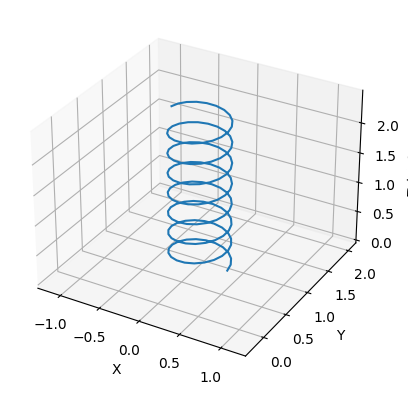

In [16]:
x, y, z = draw_spiral((.0, 0.9, .0), 0.35, 2.5/150)
plot_trajectory(x, y, z)

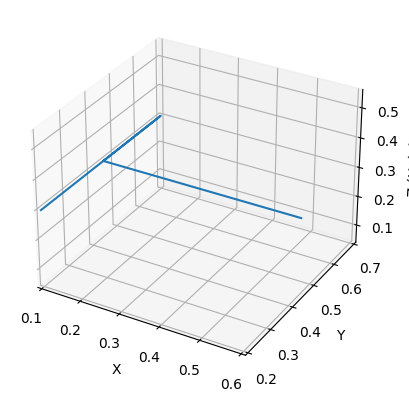

In [17]:
x, y, z = draw_T_shape((0.1, 0.2, 0.3), 0.5, 0.5)
plot_trajectory(x, y, z)

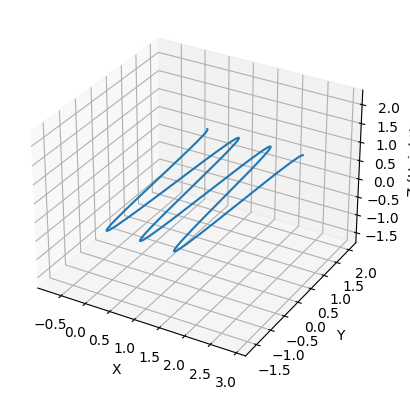

In [18]:
x, y, z = draw_curve_line2((0.1, 0.2, 0.3), 2, 2/150)
plot_trajectory(x, y, z)

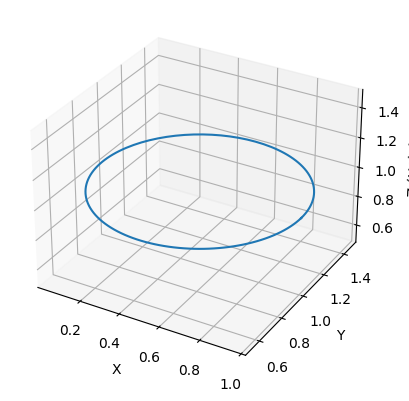

In [19]:
x, y, z = draw_ellipse((1.0, 1.0, 1.0), 0.5, 0.5)
plot_trajectory(x, y, z)

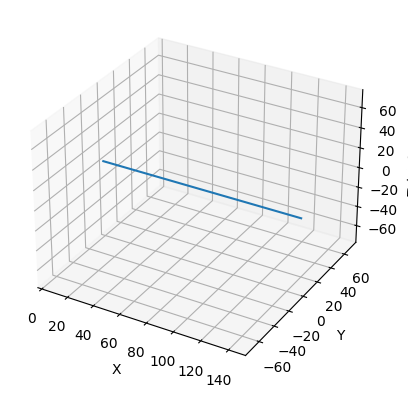

In [20]:
x, y, z = draw_straight_line((0.0, 0.0, 0.0), 1.0, steps=150)
plot_trajectory(x, y, z)

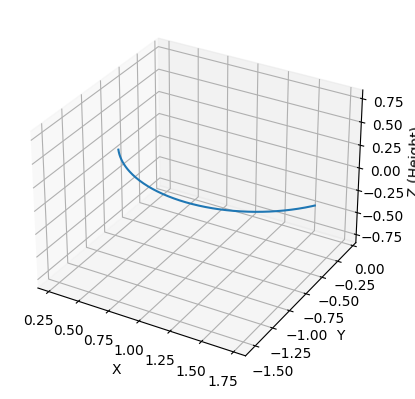

In [21]:
x, y, z = draw_semicircle((0.0, 0.0, 0.0), 1.0, steps=150)
plot_trajectory(x, y, z)

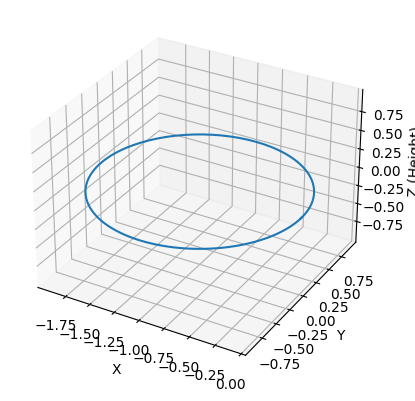

In [22]:
x, y, z = draw_circle((0.0, 0.0, 0.0), 1.0, steps=150)
plot_trajectory(x, y, z)

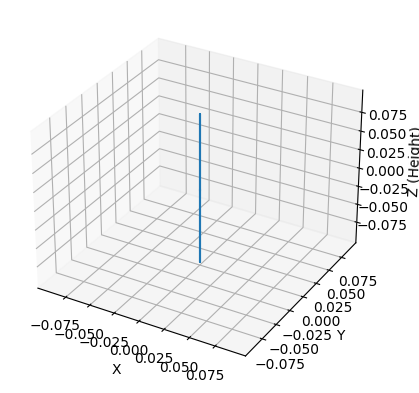

In [23]:
x, y, z = draw_up_down_line(start_z=.0, radius=0.1, theta_step=20, steps=150)
plot_trajectory(x, y, z)

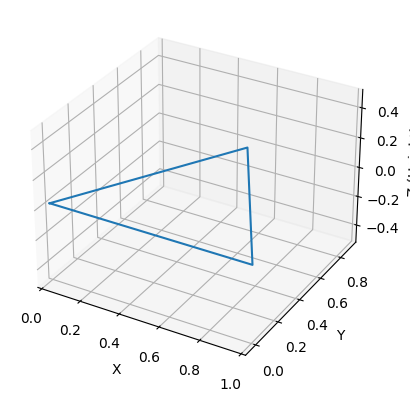

In [24]:
x, y, z = draw_equilateral_triangle((0.0, 0.0, 0.0), 1.0, steps=150)
plot_trajectory(x, y, z)

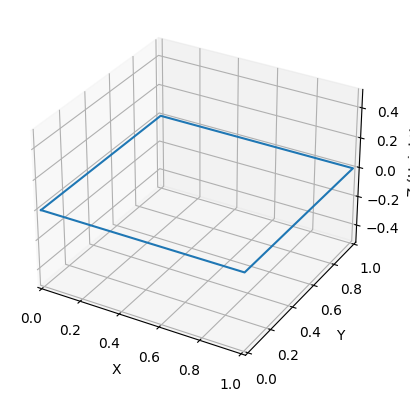

In [25]:
x, y, z = draw_square((0.0, 0.0, 0.0), 1.0, steps=150)
plot_trajectory(x, y, z)

Loaded trajectory gLO_sBM_cAll_d15_mLO2_ch02.npy with shape: torch.Size([825, 3])
Visualizing trajectory gLO_sBM_cAll_d15_mLO2_ch02.npy


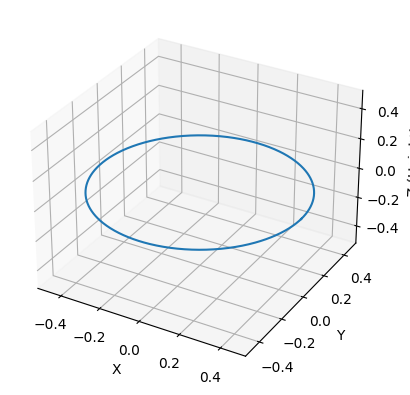

Loaded trajectory gKR_sBM_cAll_d30_mKR2_ch02.npy with shape: torch.Size([825, 3])
Visualizing trajectory gKR_sBM_cAll_d30_mKR2_ch02.npy


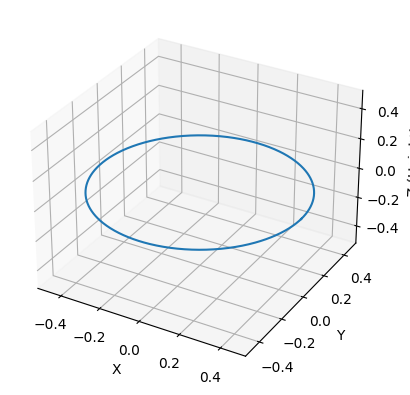

Loaded trajectory gHO_sBM_cAll_d20_mHO5_ch02.npy with shape: torch.Size([450, 3])
Visualizing trajectory gHO_sBM_cAll_d20_mHO5_ch02.npy


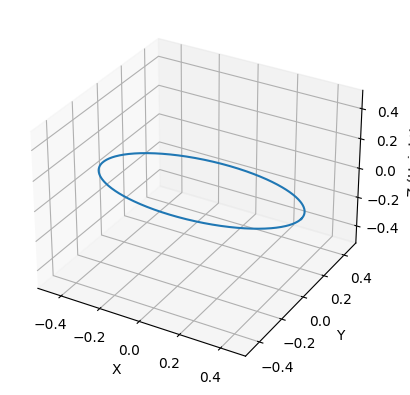

Loaded trajectory gWA_sBM_cAll_d25_mWA0_ch02.npy with shape: torch.Size([1125, 3])
Visualizing trajectory gWA_sBM_cAll_d25_mWA0_ch02.npy


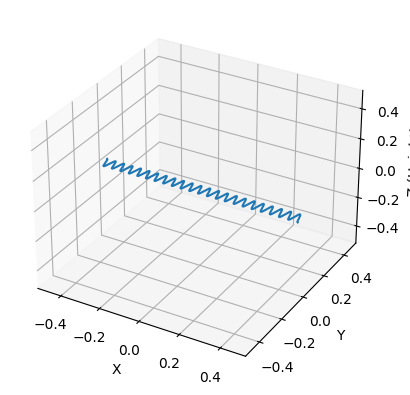

Loaded trajectory gMH_sBM_cAll_d24_mMH3_ch02.npy with shape: torch.Size([675, 3])
Visualizing trajectory gMH_sBM_cAll_d24_mMH3_ch02.npy


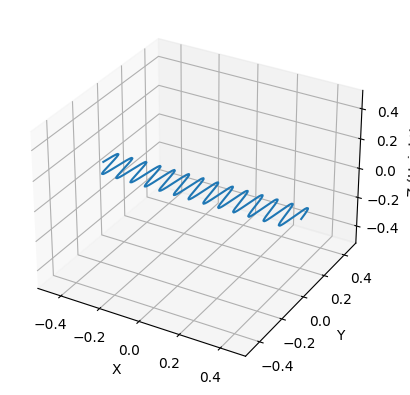

Loaded trajectory gPO_sBM_cAll_d11_mPO1_ch02.npy with shape: torch.Size([975, 3])
Visualizing trajectory gPO_sBM_cAll_d11_mPO1_ch02.npy


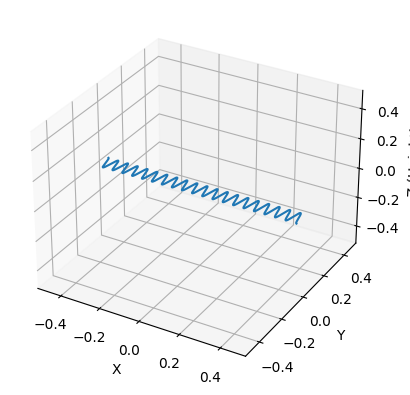

Loaded trajectory gHO_sBM_cAll_d21_mHO5_ch02.npy with shape: torch.Size([450, 3])
Visualizing trajectory gHO_sBM_cAll_d21_mHO5_ch02.npy


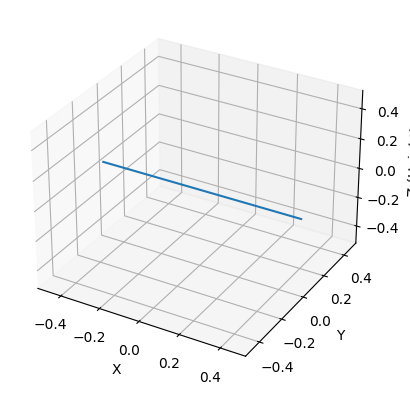

Loaded trajectory gPO_sBM_cAll_d10_mPO1_ch02.npy with shape: torch.Size([975, 3])
Visualizing trajectory gPO_sBM_cAll_d10_mPO1_ch02.npy


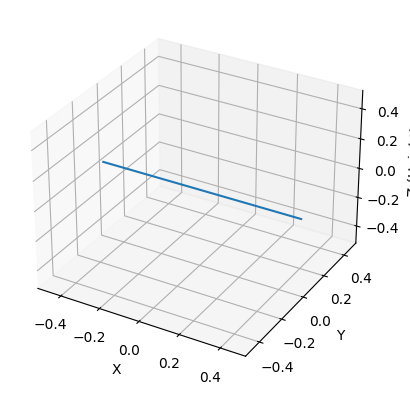

Loaded trajectory gBR_sBM_cAll_d05_mBR0_ch02.npy with shape: torch.Size([1125, 3])
Visualizing trajectory gBR_sBM_cAll_d05_mBR0_ch02.npy


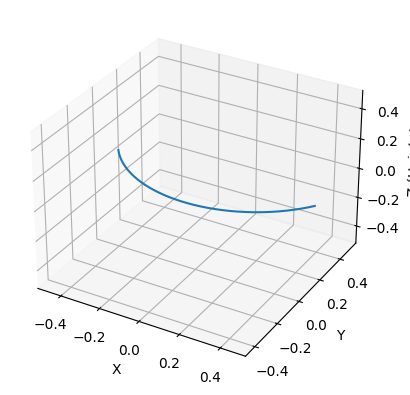

Loaded trajectory gJB_sBM_cAll_d08_mJB5_ch02.npy with shape: torch.Size([450, 3])
Visualizing trajectory gJB_sBM_cAll_d08_mJB5_ch02.npy


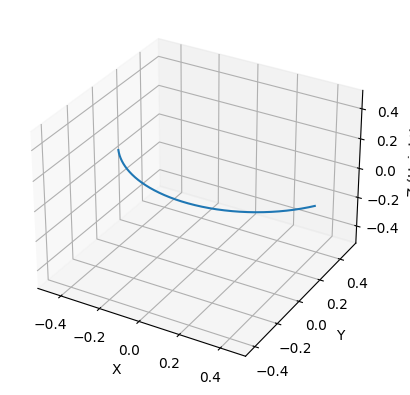

Loaded trajectory gBR_sBM_cAll_d04_mBR0_ch02.npy with shape: torch.Size([1125, 3])
Visualizing trajectory gBR_sBM_cAll_d04_mBR0_ch02.npy


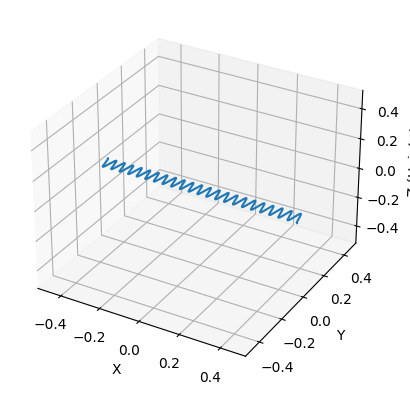

Loaded trajectory gMH_sBM_cAll_d22_mMH3_ch02.npy with shape: torch.Size([675, 3])
Visualizing trajectory gMH_sBM_cAll_d22_mMH3_ch02.npy


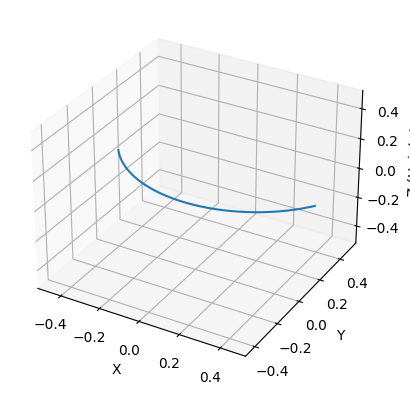

Loaded trajectory gJB_sBM_cAll_d09_mJB5_ch02.npy with shape: torch.Size([450, 3])
Visualizing trajectory gJB_sBM_cAll_d09_mJB5_ch02.npy


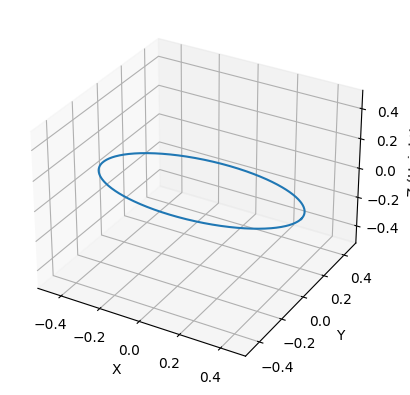

Loaded trajectory gKR_sBM_cAll_d28_mKR2_ch02.npy with shape: torch.Size([825, 3])
Visualizing trajectory gKR_sBM_cAll_d28_mKR2_ch02.npy


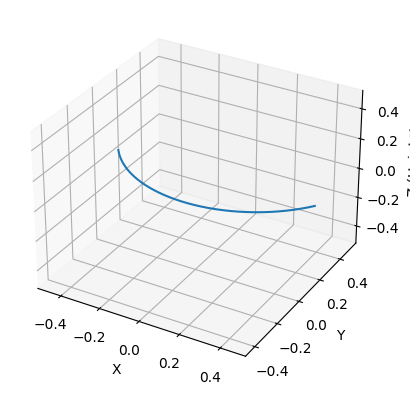

Loaded trajectory gLH_sBM_cAll_d17_mLH4_ch02.npy with shape: torch.Size([600, 3])
Visualizing trajectory gLH_sBM_cAll_d17_mLH4_ch02.npy


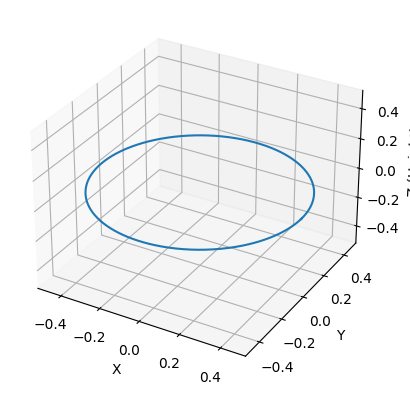

Loaded trajectory gWA_sBM_cAll_d26_mWA0_ch02.npy with shape: torch.Size([1125, 3])
Visualizing trajectory gWA_sBM_cAll_d26_mWA0_ch02.npy


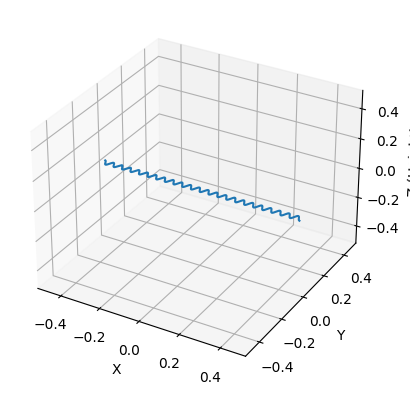

Loaded trajectory gLH_sBM_cAll_d18_mLH4_ch02.npy with shape: torch.Size([600, 3])
Visualizing trajectory gLH_sBM_cAll_d18_mLH4_ch02.npy


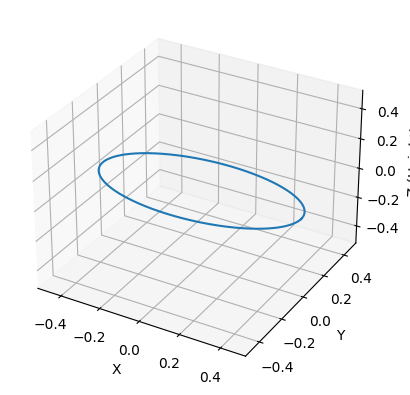

Loaded trajectory gJS_sBM_cAll_d03_mJS3_ch02.npy with shape: torch.Size([675, 3])
Visualizing trajectory gJS_sBM_cAll_d03_mJS3_ch02.npy


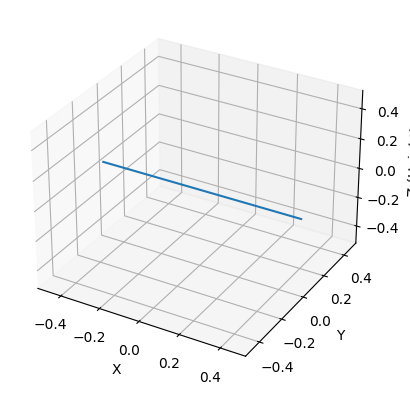

Loaded trajectory gJS_sBM_cAll_d01_mJS3_ch02.npy with shape: torch.Size([675, 3])
Visualizing trajectory gJS_sBM_cAll_d01_mJS3_ch02.npy


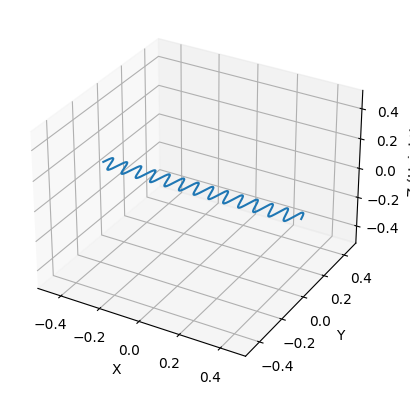

Loaded trajectory gLO_sBM_cAll_d13_mLO2_ch02.npy with shape: torch.Size([825, 3])
Visualizing trajectory gLO_sBM_cAll_d13_mLO2_ch02.npy


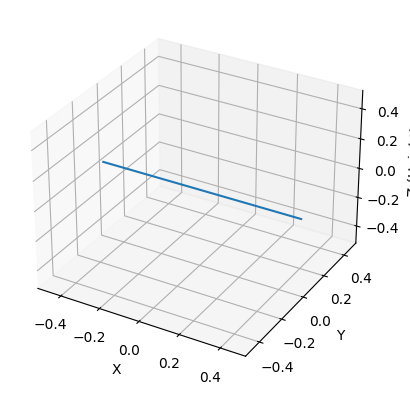

In [27]:
# check created trajectory
trajectory_path = '../data/trajectories_full/'  # Adjust the path as needed
for filename in os.listdir(trajectory_path):
    if filename.endswith('.npy'):
        traj = np.load(os.path.join(trajectory_path, filename))
        traj = torch.from_numpy(traj)
        print(f"Loaded trajectory {filename} with shape: {traj.shape}")
        # Optionally visualize the trajectory
        if traj.shape[1] == 3:  # Assuming 3D trajectory
            print(f"Visualizing trajectory {filename}")
            plot_trajectory(traj[:, 0].numpy(), traj[:, 1].numpy(), traj[:, 2].numpy())

In [ ]:
# # check created trajectory
# trajectory_path = 'data/trajectories_sliced/'

# for filename in os.listdir(trajectory_path):
#     if filename.endswith('.npy'):
#         traj = np.load(os.path.join(trajectory_path, filename))
#         traj = torch.from_numpy(traj)
#         print(f"Loaded trajectory {filename} with shape: {traj.shape}")
#         # Optionally visualize the trajectory
#         if traj.shape[1] == 3:  # Assuming 3D trajectory
#             print(f"Visualizing trajectory {filename}")
#             plot_trajectory(traj[:, 0].numpy(), traj[:, 1].numpy(), traj[:, 2].numpy())